### Customer Service Bot with Human Escalation
        Task:
        Create a Customer Service Agent with human-in-the-loop:
        Handle common queries automatically
        Escalate complex issues to humans
        Manage ticket creation and tracking

The actual flow should be:

        Start → classify_query
        classify_query → handle_common_query (if common query)
        classify_query → create_ticket (if needs human)
        handle_common_query → create_ticket (if needs escalation after handling)
        handle_common_query → END (if resolved)
        create_ticket → human_handoff → human_intervention → END

In [33]:

import os 
import getpass
import uuid
import json
import datetime
from typing import Annotated, Dict, List, Any, Optional
from typing_extensions import TypedDict, Literal
from enum import Enum

# Setup environment variables
def setup_environment():
    """Setup your API KEYs"""
    if not os.environ.get("OPENAI_API_KEY"):
        openai_key = getpass.getpass("Enter your OPENAI API KEY")
        os.environ["OPENAI_API_KEY"] = openai_key

    if not os.environ.get("LANGSMITH_API_KEY"):
        langsmith_key = getpass.getpass("ENTER your LAngsmith API KEY")
        if langsmith_key:
            os.environ["LANGSMITH_API_KEY"] = langsmith_key
            os.environ["LANGCHAIN_TRACING_V2"] ="true"
            os.environ["LANGCHAIN_PROJECT"] = "Customer Service Bot"
        else:
            print("skipping langsmith set up")

    print("Environment setup completed")

setup_environment()



Environment setup completed


In [34]:
# Import required libraries
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt, Command
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig
import operator
from typing import Union, List as ListType, Dict as DictType, Any, Callable



In [35]:
# Define ticket status enum
class TicketStatus(str, Enum):
    NEW = "new"
    IN_PROGRESS = "in_progress"
    WAITING_FOR_HUMAN = "waiting_for_human"
    WAITING_FOR_CUSTOMER = "waiting_for_customer"
    RESOLVED = "resolved"
    CLOSED = "closed"

# Define state classes
class Message(BaseModel):
    role: str
    content: str

class Ticket(BaseModel):
    ticket_id: str
    customer_id: str
    subject: str
    description: str
    status: TicketStatus
    priority: int
    created_at: str
    updated_at: str
    assigned_to: Optional[str] = None
    category: Optional[str] = None
    
class CustomerState(TypedDict):
    # Use add_messages to append new messages instead of replacing them
    messages: Annotated[List, add_messages]  # This will store LangChain message objects
    current_ticket: Optional[dict]
    issue_resolved: bool
    needs_human: bool
    response: str

# Define model for classification output
class QueryClassification(BaseModel):
    is_common_query: bool = Field(description="Whether this is a common query that can be handled automatically")
    confidence_score: float = Field(description="Confidence score between 0 and 1")
    category: str = Field(description="Category of the customer query: billing, technical, account, product, other")
    estimated_complexity: int = Field(description="Estimated complexity from 1-5, where 5 is most complex")
    
# Define model for ticket creation
class TicketCreation(BaseModel):
    subject: str = Field(description="Brief description of the issue for the ticket subject")
    description: str = Field(description="Detailed description of the customer issue")
    priority: int = Field(description="Priority from 1-5, where 5 is highest priority")
    category: str = Field(description="Category of the issue: billing, technical, account, product, other")

# Define model for response
class ResponseModel(BaseModel):
    response: str = Field(description="Response to the customer")
    is_resolved: bool = Field(description="Whether the issue is resolved")
    needs_human: bool = Field(description="Whether a human needs to intervene")
    reason_for_escalation: Optional[str] = Field(description="Reason for escalation if needs_human is True")



In [36]:
# Helper to get the language model
def get_llm():
    return ChatOpenAI(
        model="gpt-4o",
        temperature=0.0
    )

# Mock database for tickets
class TicketDatabase:
    def __init__(self):
        self.tickets = {}
        
    def create_ticket(self, customer_id, subject, description, priority=3, category=None):
        ticket_id = f"TICKET-{uuid.uuid4().hex[:8]}"
        now = datetime.datetime.now().isoformat()
        
        ticket = Ticket(
            ticket_id=ticket_id,
            customer_id=customer_id,
            subject=subject,
            description=description,
            status=TicketStatus.NEW,
            priority=priority,
            created_at=now,
            updated_at=now,
            category=category
        )
        
        self.tickets[ticket_id] = ticket.dict()
        return self.tickets[ticket_id]
        
    def update_ticket(self, ticket_id, **kwargs):
        if ticket_id in self.tickets:
            for key, value in kwargs.items():
                if key in self.tickets[ticket_id]:
                    self.tickets[ticket_id][key] = value
            self.tickets[ticket_id]["updated_at"] = datetime.datetime.now().isoformat()
            return self.tickets[ticket_id]
        return None
        
    def get_ticket(self, ticket_id):
        return self.tickets.get(ticket_id)
        
    def search_tickets(self, customer_id=None, status=None):
        results = []
        for ticket in self.tickets.values():
            if customer_id and ticket["customer_id"] != customer_id:
                continue
            if status and ticket["status"] != status:
                continue
            results.append(ticket)
        return results

# Create ticket database instance
ticket_db = TicketDatabase()



In [37]:
# Functions for customer service workflow
def classify_query(state: CustomerState):
    """Classify if the query is common or needs human intervention"""
    messages = state.get("messages", [])
    if not messages:
        return {"needs_human": False}
    
    last_message = messages[-1]
    # Check if message is a HumanMessage object
    if not isinstance(last_message, HumanMessage):
        return {"needs_human": False}
    
    # Create a parser for the structured output
    parser = PydanticOutputParser(pydantic_object=QueryClassification)
    format_instructions = parser.get_format_instructions()
    
    # Past conversation context
    conversation_history = "\n".join(
        [f"{type(m).__name__.replace('Message', '')}: {m.content}" for m in messages[:-1]]
    ) if len(messages) > 1 else "No previous conversation"
    
    prompt = ChatPromptTemplate.from_template(
        "You are a customer service triage system.\n\n" +
        "Please classify the following customer query:\n\n" +
        "Customer query: {query}\n\n" +
        "Previous conversation:\n{conversation_history}\n\n" +
        "Classify whether this is a common query that can be handled automatically, or if it needs to be escalated to a human agent.\n" +
        "Common queries include: account information requests, basic troubleshooting steps, billing inquiries with clear information, etc.\n" +
        "Queries requiring human intervention include: complex technical issues, billing disputes, multiple failed resolution attempts, explicitly asking for a human, etc.\n\n" +
        "{format_instructions}"
    )
    
    # Create a chain that will use the parser to extract structured output
    chain = prompt | get_llm() | parser
    
    # Run the chain
    result = chain.invoke({
        "query": last_message.content,
        "conversation_history": conversation_history,
        "format_instructions": format_instructions
    })
    
    return {
        "needs_human": result.is_common_query == False or result.confidence_score < 0.7 or result.estimated_complexity > 3
    }

In [38]:
def handle_common_query(state: CustomerState):
    """Handle common customer service queries"""
    messages = state["messages"]
    last_message = messages[-1] if messages else None
    if not last_message or not isinstance(last_message, HumanMessage):
        return {"response": "I couldn't understand your message.", "issue_resolved": False, "needs_human": True}
    
    # Create a parser for the structured output
    parser = PydanticOutputParser(pydantic_object=ResponseModel)
    format_instructions = parser.get_format_instructions()
    
    # Past conversation context
    conversation_history = "\n".join(
        [f"{type(m).__name__.replace('Message', '')}: {m.content}" for m in messages[:-1]]
    ) if len(messages) > 1 else "No previous conversation"
    
    prompt = ChatPromptTemplate.from_template(
        "You are a helpful customer service AI assistant for a company.\n\n" +
        "Previous conversation:\n{conversation_history}\n\n" +
        "Customer query: {query}\n\n" +
        "Provide a helpful and friendly response to the customer. If you're able to fully address their query, mark the issue as resolved.\n" +
        "If at any point you determine this requires human expertise, indicate that in your response.\n\n" +
        "{format_instructions}"
    )
    
    # Create a chain that will use the parser to extract structured output
    chain = prompt | get_llm() | parser
    
    # Run the chain
    result = chain.invoke({
        "query": last_message.content,
        "conversation_history": conversation_history,
        "format_instructions": format_instructions
    })
    
    return {
        "response": result.response,
        "issue_resolved": result.is_resolved,
        "needs_human": result.needs_human
    }

def create_support_ticket(state: CustomerState):
    """Create a support ticket for issues that need human assistance"""
    messages = state["messages"]
    
    # Create a parser for the structured output
    parser = PydanticOutputParser(pydantic_object=TicketCreation)
    format_instructions = parser.get_format_instructions()
    
    # Compile full conversation history
    conversation_history = "\n".join(
        [f"{type(m).__name__.replace('Message', '')}: {m.content}" for m in messages]
    )
    
    prompt = ChatPromptTemplate.from_template(
        "You are a customer service ticket creation system.\n\n" +
        "Based on the following conversation, create a support ticket:\n\n" +
        "Conversation history:\n{conversation_history}\n\n" +
        "Create a structured ticket with a clear subject, detailed description summarizing the issue, appropriate priority level, and category.\n\n" +
        "{format_instructions}"
    )
    
    # Create a chain that will use the parser to extract structured output
    chain = prompt | get_llm() | parser
    
    # Run the chain
    result = chain.invoke({
        "conversation_history": conversation_history,
        "format_instructions": format_instructions
    })
    
    # Customer ID would normally come from authentication system
    customer_id = "customer123"
    
    # Create ticket in database
    ticket = ticket_db.create_ticket(
        customer_id=customer_id,
        subject=result.subject,
        description=result.description,
        priority=result.priority,
        category=result.category
    )
    
    # Prepare response to customer
    response = f"I've created support ticket #{ticket['ticket_id']} for your issue. A customer service representative will review your case and get back to you as soon as possible. Your ticket priority is {result.priority}/5."
    
    return {
        "response": response,
        "current_ticket": ticket
    }

def human_handoff_message(state: CustomerState):
    """Generate a message for human handoff"""
    ticket = state.get("current_ticket")
    if not ticket:
        return {"response": "I'll connect you with a human representative. Please hold while I transfer your conversation."}
    
    # Update ticket status
    if ticket:
        ticket_db.update_ticket(ticket["ticket_id"], status=TicketStatus.WAITING_FOR_HUMAN)
    
    response = (
        f"I've escalated your issue to our customer service team. Your ticket ID is {ticket['ticket_id']}.\n" +
        f"A representative will review your case and contact you as soon as possible.\n" +
        f"Is there anything else you'd like to add to your ticket while we wait for a human representative?"
    )
    
    return {"response": response}

In [39]:
def route_query(state: CustomerState) -> str:
    """Route the query based on whether it needs human intervention"""
    if state["needs_human"]:
        # Check if there's already a ticket
        if state.get("current_ticket"):
            return "human_handoff"
        else:
            return "create_ticket"
    else:
        return "handle_common_query"

def need_ticket_creation(state: CustomerState) -> str:
    """Determine if a ticket needs to be created"""
    if state["needs_human"]:
        return "create_ticket" 
    else:
        return END

# Define the human reply handler
def human_reply_handler(state: CustomerState, human_input: str) -> dict:
    """Process the human support agent's reply"""
    return {
        "messages": [AIMessage(content=f"[SUPPORT AGENT]: {human_input}")],
        "response": human_input
    }

def human_input_node(state: CustomerState):
    """Node that represents human intervention in the workflow"""
    # This node pauses the workflow and waits for human input using the interrupt mechanism
    ticket_info = ""
    if state.get("current_ticket"):
        ticket = state["current_ticket"]
        ticket_info = f"\nTicket #{ticket['ticket_id']}\nPriority: {ticket['priority']}\nIssue: {ticket['description']}"
    
    # Interrupt and wait for human input
    human_response = interrupt({
        "message": "This query requires human intervention.",
        "ticket_info": ticket_info,
        "conversation_history": state["messages"],
    })
    
    # When execution resumes, human_response will contain the agent's input
    return {
        "messages": [AIMessage(content=f"[SUPPORT AGENT]: {human_response}")],
        "response": f"Support agent has responded: {human_response}"
    }

In [40]:
def get_customer_service_workflow():
    # Initialize the state graph with a checkpointer for persistence
    checkpointer = InMemorySaver()
    
    # Define the graph
    builder = StateGraph(CustomerState)
    
    # Add nodes to the workflow
    builder.add_node("classify_query", classify_query)
    builder.add_node("handle_common_query", handle_common_query)
    builder.add_node("create_ticket", create_support_ticket)
    builder.add_node("human_handoff", human_handoff_message)
    builder.add_node("human_intervention", human_input_node)
    
    # Define the workflow edges

    builder.add_edge(START, "classify_query")

    builder.add_conditional_edges("classify_query", lambda state: {
    "handle_common_query": state["type"] == "common",
    "create_ticket": state["type"] == "support",
    "human_intervention": state["type"] == "unknown"
})

    # builder.add_conditional_edges("classify_query", route_query)
    
    builder.add_conditional_edges(
        "handle_common_query",
        lambda state: "create_ticket" if state["needs_human"] else END
    )
    
    builder.add_edge("create_ticket", "human_handoff")
    builder.add_edge("human_handoff", "human_intervention")
    
    # From human intervention, we end the workflow
    builder.add_edge("human_intervention", END)
    
    # Compile the graph with checkpoint support
    app = builder.compile(checkpointer=checkpointer)
    
    return app

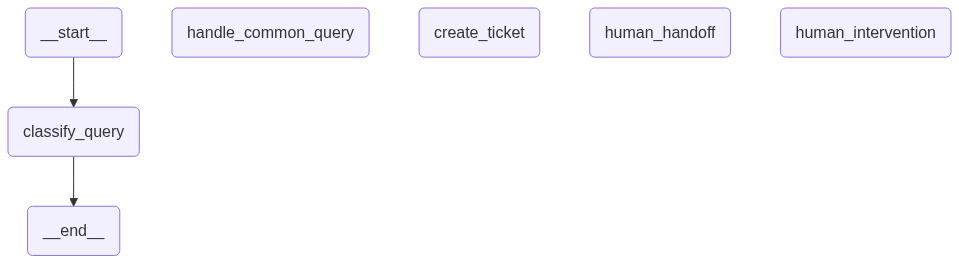

In [41]:
workflow = get_customer_service_workflow()



from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [42]:
# Interactive chat function with human-in-the-loop support
def interactive_customer_service():
    # Create the workflow
    customer_service = get_customer_service_workflow()
    thread_id = None
    conversation_active = True
    
    print("\n=== Customer Service Bot with Human Escalation ===\n")
    print("Type 'exit' to end the conversation\n")
    
    # Initialize the state
    state = {
        "messages": [SystemMessage(content="You are a helpful customer service assistant.")],
        "current_ticket": None,
        "issue_resolved": False,
        "response": ""
    }
    
    # Start the conversation
    while conversation_active:
        # Get user input
        user_input = input("\nYou: ")
        
        # Check for exit command
        if user_input.lower() == "exit":
            print("\nThank you for using the customer service bot. Goodbye!")
            conversation_active = False
            continue
        
        try:
            # Add the user's message to the conversation history
            state["messages"] = state["messages"] + [HumanMessage(content=user_input)]
            
            # Create a unique thread ID if we don't have one yet
            if thread_id is None:
                thread_id = str(uuid.uuid4())
                config = {"configurable": {"thread_id": thread_id}}
            else:
                config = {"configurable": {"thread_id": thread_id}}
                
            # Process the user's input with the current state
            thread = customer_service.invoke(state, config=config)
                
            # Check if the workflow was interrupted for human intervention
            if "__interrupt__" in thread:
                print(f"\nCustomer Service Bot: {thread.get('response', 'I need assistance from a human agent.')}")
                interrupt_data = thread["__interrupt__"][0].value
                print("\n[System] " + interrupt_data.get("message", "This query requires human intervention."))
                
                # Display ticket information if available
                if interrupt_data.get("ticket_info"):
                    print(interrupt_data["ticket_info"])
                
                # Simulate a human support agent providing input
                human_agent_input = input("\nSupport Agent: ")
                
                # Resume the workflow with the human input
                thread = customer_service.invoke(Command(resume=human_agent_input), config=config)
                
                # Print the workflow's response after human intervention
                print(f"\nBot: {thread['response']}")
            else:
                # Print the bot's response
                print(f"\nBot: {thread['response']}")
                
                # Display ticket information if created (only if it's new or updated)
                if thread.get("current_ticket") and (not state.get("current_ticket") or 
                   thread["current_ticket"]["ticket_id"] != state.get("current_ticket", {}).get("ticket_id")):
                    ticket = thread["current_ticket"]
                    print(f"\n[Ticket #{ticket['ticket_id']} created | Priority: {ticket['priority']}/5 | Status: {ticket['status']}]")
                # Or if the ticket status has changed
                elif thread.get("current_ticket") and state.get("current_ticket") and \
                     thread["current_ticket"]["status"] != state["current_ticket"]["status"]:
                    ticket = thread["current_ticket"]
                    print(f"\n[Ticket #{ticket['ticket_id']} updated | Status: {ticket['status']}]")
                
            # Update the state with the new thread state
            state = thread
                
        except Exception as e:
            print(f"\nError: {e}")
            print("Let's start a new conversation.")
            thread_id = None
            state = {
                "messages": [SystemMessage(content="You are a helpful customer service assistant.")],
                "current_ticket": None,
                "issue_resolved": False,
                "response": ""
            }

In [44]:
# Example usage
if __name__ == "__main__":
    # Example customer queries to demonstrate functionality
    examples = [
        # Common query that can be handled automatically
        "What are your business hours?",
        
        # Technical issue that needs human intervention
        "I've been trying to reset my password for 3 days and the reset email never arrives. I've checked my spam folder multiple times and tried with different email addresses. This is very frustrating!",
        
        # Billing dispute requiring human intervention
        "I was charged twice for my monthly subscription. I need this refunded immediately.",
        
        # Simple product question
        "Do you offer next-day delivery?"
    ]
    
    print("\n=== Customer Service Bot with Human-in-the-Loop ===\n")
    print("This demo showcases a customer service bot that can:\n")
    print("1. Handle common queries automatically")
    print("2. Create support tickets for complex issues")
    print("3. Escalate to human agents when needed")
    print("4. Use LangGraph's interrupt mechanism for human-in-the-loop functionality\n")
    
    print("Example queries you can try:\n")
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example}")
    
    print("\nStarting interactive conversation...")
    
    # Start the interactive customer service bot
    interactive_customer_service()



=== Customer Service Bot with Human-in-the-Loop ===

This demo showcases a customer service bot that can:

1. Handle common queries automatically
2. Create support tickets for complex issues
3. Escalate to human agents when needed
4. Use LangGraph's interrupt mechanism for human-in-the-loop functionality

Example queries you can try:

1. What are your business hours?
2. I've been trying to reset my password for 3 days and the reset email never arrives. I've checked my spam folder multiple times and tried with different email addresses. This is very frustrating!
3. I was charged twice for my monthly subscription. I need this refunded immediately.
4. Do you offer next-day delivery?

Starting interactive conversation...

=== Customer Service Bot with Human Escalation ===

Type 'exit' to end the conversation


Error: 'type'
Let's start a new conversation.

Error: 'type'
Let's start a new conversation.

Thank you for using the customer service bot. Goodbye!
